In [ ]:
import os
os.chdir("/Users/dustinhayes/Desktop/GitHub/stable-credit-risk-modeling/")
import polars as pl
import pandas as pd
import numpy as np
from importlib import reload
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
from ..DataProcessing.pipeline import Pipeline


ROOT = Path('/Users/dustinhayes/Desktop/GitHub/stable-credit-risk-modeling/Data')
TRAIN_DIR = ROOT / "original_parquet_files" / "train"
TEST_DIR = ROOT / "original_parquet_files" / "test"
FEATURE_DEFINITIONS = ROOT / "feature_definitions.csv"

In [92]:
import os
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  /Users/dustinhayes/Desktop/GitHub/stable-credit-risk-modeling/DataExploration


We have access to a csv which contains definitions for each feature. It would be nice to be able to print out a df and anutomatically retreive information on each column. I'll write a quick function to do that.

In [47]:
feature_def_df = pd.read_csv(FEATURE_DEFINITIONS)
SEPERATOR = "==============================================================================="

def print_df_and_define_columns(df):
    cols = df.columns
    col_defs = feature_def_df[feature_def_df['Variable'].isin(cols)]
    print(SEPERATOR)
    for index, row in col_defs.iterrows():
        variable = row.Variable
        description = row.Description
        print(f"{variable}: {description}")
        print(SEPERATOR)
    print(df)


We should take some time to explore some depth 1 and depth 2 tables to speculate on appropriate methods of aggregation.

Let's take example depth 1 table "train_tax_registry_a_1.parquet"

In [44]:
tax_registry_a_1_path = TRAIN_DIR / "train_tax_registry_a_1.parquet"
tax_reg_a1_df = pl.read_parquet(tax_registry_a_1_path)
print_df_and_define_columns(tax_reg_a1_df)


amount_4527230A: Tax deductions amount tracked by the government registry.
name_4527232M: Name of employer.
recorddate_4527225D: Date of tax deduction record.
shape: (3_275_770, 5)
┌─────────┬─────────────────┬───────────────┬────────────┬─────────────────────┐
│ case_id ┆ amount_4527230A ┆ name_4527232M ┆ num_group1 ┆ recorddate_4527225D │
│ ---     ┆ ---             ┆ ---           ┆ ---        ┆ ---                 │
│ i64     ┆ f64             ┆ str           ┆ i64        ┆ str                 │
╞═════════╪═════════════════╪═══════════════╪════════════╪═════════════════════╡
│ 28631   ┆ 711.0           ┆ f980a1ea      ┆ 3          ┆ 2019-09-13          │
│ 28631   ┆ 1946.0          ┆ f980a1ea      ┆ 2          ┆ 2019-09-13          │
│ 28631   ┆ 2600.0          ┆ f980a1ea      ┆ 1          ┆ 2019-09-13          │
│ 28631   ┆ 3616.4001       ┆ f980a1ea      ┆ 0          ┆ 2019-09-13          │
│ 28632   ┆ 400.0           ┆ 5f9b74f5      ┆ 6          ┆ 2019-09-13          │
│ …      

It seems that in train_tax_registry_a_1.parquet we have 5 columns: case_id, amount_4527230A, name_4527232M, num_group1, recorddate_4527225D, with descriptions: 

===============================================================================
amount_4527230A: Tax deductions amount tracked by the government registry.
===============================================================================
name_4527232M: Name of employer.
===============================================================================
recorddate_4527225D: Date of tax deduction record.
===============================================================================

The precise meaning of num_group1, and num_group2 were not immediately clear to me. A post by the competition host helped:

Hi,
okay, let me explain on hypothetical example:

Tomas Jelinek applied for loan on 1.1.2024 - this is credit case, which has assigned unique case_id
Tomas Jelinek is existing client in Home Credit, it means he had applications/loans with Home Credit before 1.1.2024, let's say 5 loans. Data describing parameters of those loans, their repayment history etc. are definitely valuable for credit scoring, therefore you have them in the sample. But they are not aggregated on level of case_id, there are 5 rows describing those 5 previous loans. To differentiate between those 5, you have to have some index - num_group_1, which will contain values 0,1,2,3,4…
num_group_1 is not used only for previous applications, but for other data where we have several records per case_id, like contact references, records in credit registry, etc. What I want to say is there is different meaning for different tables & attributes
is some cases we might have even bigger detail, for example information about instalments for each previous application. Then you need num_group_2, for example let's say previous loan with num_group_1=0 have 3 instalments, then you will have 3 records with num_group_1 = 0 and num_group_2 = 0,1,2




Let's look at a depth 2 table as well. I have chosen credit_bureau_b_2_path.

In [58]:
credit_bureau_b_2_path = TRAIN_DIR / "train_credit_bureau_b_2.parquet"

credit_bureau_b_2_df = pl.read_parquet(credit_bureau_b_2_path).fill_null(0.0)
filter_case_id = credit_bureau_b_2_df.filter((pl.col('pmts_dpdvalue_108P') > 0) & (pl.col("pmts_pmtsoverdue_635A") > 0)) # Filter to one id for readability
print_df_and_define_columns(filter_case_id)
max_value = credit_bureau_b_2_df.select(pl.max('pmts_pmtsoverdue_635A')).to_numpy()[0, 0]
min_value = credit_bureau_b_2_df.select(pl.min('pmts_pmtsoverdue_635A')).to_numpy()[0, 0]
column_range = max_value - min_value

print("Range of the pmts_pmtsoverdue_635A:", column_range)

pmts_date_1107D: Payment date for an active contract according to credit bureau (num_group1 - contract, num_group2 - payment).
pmts_dpdvalue_108P: Value of past due payment for active contract (num_group1 - existing contract, num_group2 - payment).
pmts_pmtsoverdue_635A: Active contract that has overdue payments (num_group1 - existing contract, num_group2 - payment).
shape: (144_343, 6)
┌────────────┬────────────┬────────────┬─────────────────┬────────────────────┬────────────────────┐
│ case_id    ┆ num_group1 ┆ num_group2 ┆ pmts_date_1107D ┆ pmts_dpdvalue_108P ┆ pmts_pmtsoverdue_6 │
│ ---        ┆ ---        ┆ ---        ┆ ---             ┆ ---                ┆ 35A                │
│ f64        ┆ f64        ┆ f64        ┆ str             ┆ f64                ┆ ---                │
│            ┆            ┆            ┆                 ┆                    ┆ f64                │
╞════════════╪════════════╪════════════╪═════════════════╪════════════════════╪════════════════════╡
│ 14

There are five columns: case_id, num_group1, num_group2, pmts_date_1107D, pmts_dpdvalue_108P, and pmts_pmtsoverdue_635A.

This is a depth two table. The first layer of depth is existing contract. A single case_id may have multiple contracts in repayment. These multiple contracts are enumerated with num_group1. Within a single contract, multiple payments are recorded. pmts_date_1107D, pmts_dpdvalue_108P, and pmts_pmtsoverdue_635A representing payment date, value of past due contract, and active contract that has overdue payments are recorded at the payment level, enumerated with num_group2.

I am still a little confused as to the precise meaning of pmts_dpdvalue_108P, and pmts_pmtsoverdue_635A.

===============================================================================
pmts_dpdvalue_108P: Value of past due payment for active contract (num_group1 - existing contract, num_group2 - payment).
===============================================================================

Is this the amount of money that was paid past due, or is it the amount past due that remains after the payment?

P - Transform DPD (Days past due) - Float

But it says "Value", not # of days past due or anything of the sort.

Notably


===============================================================================
pmts_pmtsoverdue_635A: Active contract that has overdue payments (num_group1 - existing contract, num_group2 - payment).
===============================================================================

These are numerical values that do not seem to specify which contract is overdue. Is this how much is left past due after the payment?

I'll investigate a bit further...

105.17865482168129


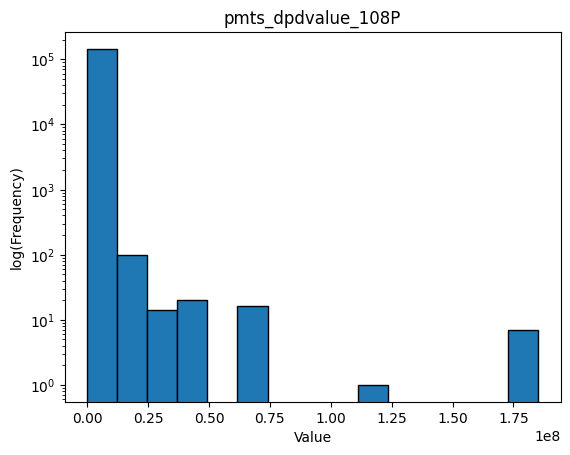

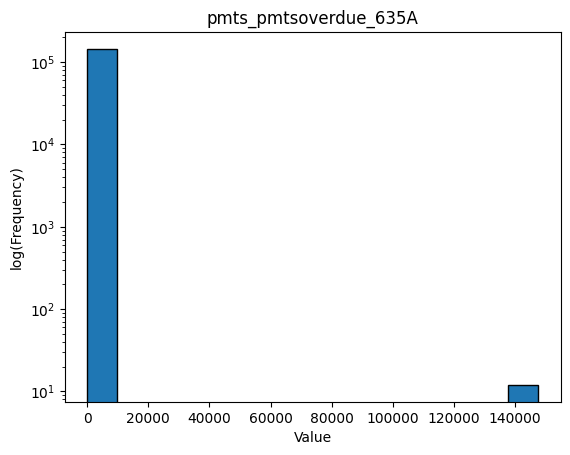

[2.00000000e-01 9.83156067e+03 1.96629213e+04 2.94942820e+04
 3.93256427e+04 4.91570033e+04 5.89883640e+04 6.88197247e+04
 7.86510853e+04 8.84824460e+04 9.83138067e+04 1.08145167e+05
 1.17976528e+05 1.27807889e+05 1.37639249e+05 1.47470610e+05]
Hist counts for pmts_pmtsoverdue_635A, in bins of around 10,000 [144472      0      0      0      0      0      0      0      0      0
      0      0      0      0     12]


In [69]:
credit_bureau_b_2_path = TRAIN_DIR / "train_credit_bureau_b_2.parquet"

credit_bureau_b_2_df = pl.read_parquet(credit_bureau_b_2_path).fill_null(0.0)
pmts_dpdvalue_108P = credit_bureau_b_2_df.get_column('pmts_dpdvalue_108P').to_numpy()
pmts_dpdvalue_108P = pmts_dpdvalue_108P[pmts_dpdvalue_108P != 0.0] # I'm interested in observing overdue payments
pmts_pmtsoverdue_635A = credit_bureau_b_2_df.get_column('pmts_pmtsoverdue_635A').to_numpy()
pmts_pmtsoverdue_635A = pmts_pmtsoverdue_635A[pmts_pmtsoverdue_635A != 0.0]

num_bins = 15

hist_pmts_dpdvalue_108P, bin_edges_pmts_dpdvalue_108P = np.histogram(pmts_dpdvalue_108P, bins=num_bins)
hist_pmts_pmtsoverdue_635A, bin_edges_pmts_pmtsoverdue_635A = np.histogram(pmts_pmtsoverdue_635A, bins=num_bins)

def plot_hist(hist_counts, bin_edges, feature):
    plt.bar(bin_edges[:-1], hist_counts, width=np.diff(bin_edges), log=True, edgecolor='black', align='edge')
    plt.title(f"{feature}")
    plt.xlabel('Value')
    plt.ylabel('log(Frequency)') # Plot log to see extreme values easier.
    plt.show()

plot_hist(hist_pmts_dpdvalue_108P, bin_edges_pmts_dpdvalue_108P, "pmts_dpdvalue_108P")
plot_hist(hist_pmts_pmtsoverdue_635A, bin_edges_pmts_pmtsoverdue_635A, "pmts_pmtsoverdue_635A")

print(bin_edges_pmts_pmtsoverdue_635A)
print(f"Hist counts for pmts_pmtsoverdue_635A, in bins of around 10,000 {hist_pmts_pmtsoverdue_635A}")


We found some interesting hist counts for pmts_pmtsoverdue_635A. With bins of around 10,000, after filtering out zeros:

[144472      0      0      0      0      0      0      0      0      0
0      0      0      0     12]

So almost everything is less than 10,000, but we have exactly 12 counts sitting around 140,000. What could this mean? 


Mean of pmts_pmtsoverdue_635A w/o the 12 outliers: 92.93936363624645


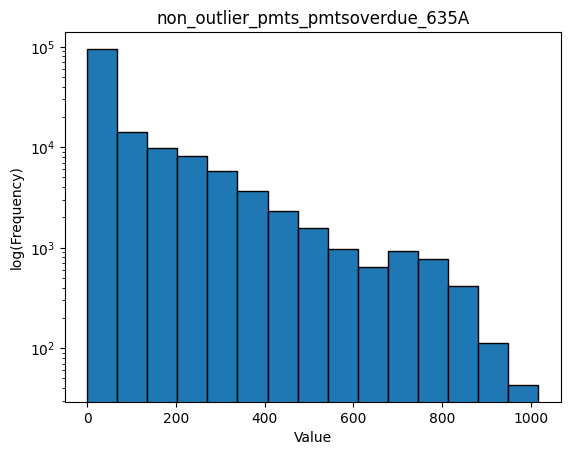

In [72]:
# Let's see what the data looks like without these 12 very large values.
non_outlier_pmts_pmtsoverdue_635A = np.sort(pmts_pmtsoverdue_635A)[:-12]
print(f"Mean of pmts_pmtsoverdue_635A w/o the 12 outliers: {np.mean(non_outlier_pmts_pmtsoverdue_635A)}")


hist_non_outlier_pmts_pmtsoverdue_635A, bin_edges_non_outlier_pmts_pmtsoverdue_635A = np.histogram(non_outlier_pmts_pmtsoverdue_635A, bins=num_bins)
plot_hist(hist_non_outlier_pmts_pmtsoverdue_635A, bin_edges_non_outlier_pmts_pmtsoverdue_635A, "non_outlier_pmts_pmtsoverdue_635A")

Without the outliers we see a right-skewed distribution with a max value of around 1000. Although we still have not explained the outliers, I doubt that the units we are dealing with is USD.

Notes on col dtype coding:

        P - Transform DPD (Days past due) - Float
        M - Masking categories - String
        A - Transform amount - Float
        D - Transform date - Date
        T - Unspecified Transform - Not handled
        L - Unspecified Transform - Not handled

So far I have observed:
         - mts_dpdvalue_108P:
                - Always a whole number.
                - Suffix "P" is supposed to mean it is days past due transformed, but that does not seems to align with its description: "Value of past due payment for active contract (num_group1 - existing contract, num_group2 - payment)"
        - pmts_pmtsoverdue_635A:
                - Is usually less than 1000, but there are 12 records with values around 140,000 with nothing in between.
                - Is not always a whole number, but it a multiple of .2 for some reason
        - One of these columns may be zero when the other is not.

In [83]:
high_pmtsoverdue = credit_bureau_b_2_df.filter(pl.col("pmts_pmtsoverdue_635A") > 10000)
non_zero_pmtsoverdue = credit_bureau_b_2_df.filter(pl.col("pmts_pmtsoverdue_635A") > 0.0)
specific_case_id = credit_bureau_b_2_df.filter(pl.col("case_id") == 1445)
print(specific_case_id)

# Is one always zero when the other is zero?
# check_if_empty = credit_bureau_b_2_df.filter((pl.col("pmts_pmtsoverdue_635A") == 0) & (pl.col("pmts_dpdvalue_108P") != 0))
# print(check_if_empty)

shape: (83, 6)
┌─────────┬────────────┬────────────┬─────────────────┬────────────────────┬───────────────────────┐
│ case_id ┆ num_group1 ┆ num_group2 ┆ pmts_date_1107D ┆ pmts_dpdvalue_108P ┆ pmts_pmtsoverdue_635A │
│ ---     ┆ ---        ┆ ---        ┆ ---             ┆ ---                ┆ ---                   │
│ f64     ┆ f64        ┆ f64        ┆ str             ┆ f64                ┆ f64                   │
╞═════════╪════════════╪════════════╪═════════════════╪════════════════════╪═══════════════════════╡
│ 1445.0  ┆ 0.0        ┆ 0.0        ┆ 2016-01-15      ┆ 0.0                ┆ 0.0                   │
│ 1445.0  ┆ 0.0        ┆ 1.0        ┆ 2016-02-15      ┆ 0.0                ┆ 0.0                   │
│ 1445.0  ┆ 0.0        ┆ 2.0        ┆ 2016-03-15      ┆ 9517.0             ┆ 0.4                   │
│ 1445.0  ┆ 0.0        ┆ 3.0        ┆ 2016-04-15      ┆ 0.0                ┆ 0.0                   │
│ 1445.0  ┆ 0.0        ┆ 4.0        ┆ 2016-05-15      ┆ 0.0                ┆

It seems that I have chosen to investigate a table which has confused other kagglers as well. I found a thread which discusses exactly this, but offers no definitive conclusion: https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/discussion/478631

I found another thread, https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/discussion/485634, where user aahhammer offers this explaination:


- the num_group1 in credit_bureau_b_2 referes to the num_group1 in credit_bureau_b_1.
- Its all client credits. In your case 1702371 the client has only two documented credits
Look at e.g. case 1445 to see a different scenario with 0-4 in num_group1
- the DPD value of 9186 is rather the monetary value which was paid late
the 0.2 [in pmts_pmtsoverdue_635A] are rather the percentage of the total credit value. the total credit value is documented in credit_bureau_b_1 column amount_1115A with 43998.0. 9186 is about 20% of that value. I rather trust the data then the documentation here.

I'm not quite convinced, though. If pmts_pmtsoverdue_635A represent percentage of total credit value, anything above 1.0 would not make sense. We regularly see values over 1.0, and the max of this column is 140,000. 

Let's bring in credit_bureau_b_1, which contains total credit value, and see if the aahhammer's hypothesis regarding pmts_pmtsoverdue_635A is justified.


In [85]:
credit_bureau_b_1_path = TRAIN_DIR / "train_credit_bureau_b_1.parquet"
credit_bureau_b_1_df = pl.read_parquet(credit_bureau_b_1_path)
print_df_and_define_columns(credit_bureau_b_1_df)

amount_1115A: Credit amount of the active contract provided by the credit bureau.
classificationofcontr_1114M: Classificiation of the active contract.
contractdate_551D: Contract date of the active contract
contractmaturitydate_151D: End date of active contract.
contractst_516M: Contract status.
contracttype_653M: Contract Type
credlmt_1052A: Credit limit of an active loan.
credlmt_228A: Credit limit for closed loans.
credlmt_3940954A: Credit limit for active loan.
credor_3940957M: Creditor's name
credquantity_1099L: Number of credits in credit bureau
credquantity_984L: Number of closed credits in credit bureau.
debtpastduevalue_732A: Amount of unpaid debt for existing contracts.
debtvalue_227A: Outstanding amount for existing debt contracts.
dpd_550P: The number of days past due for active loans where a guarantee has been provided.
dpd_733P: Days past due (DPD) for guaranteed loans that were terminated according to credit bureau data.
dpdmax_851P: Maximal past due days for active cont

In [87]:
cb_joined = credit_bureau_b_2_df.join(
    credit_bureau_b_1_df, 
    on="case_id", 
    how="left"
).select([
    credit_bureau_b_2_df["case_id"],
    credit_bureau_b_2_df["pmts_pmtsoverdue_635A"],
    credit_bureau_b_2_df["other_value"],
    credit_bureau_b_2_df["pmts_dpdvalue_108P"],
    credit_bureau_b_1_df["amount_1115A"]
])


ComputeError: datatypes of join keys don't match - `case_id`: f64 on left does not match `case_id`: i64 on right